# GPX Pacenotes Generator v3

In [10]:
import numpy as np
import gpxpy
import matplotlib.pyplot as plt
import pandas as pd
import folium
import geopy.distance
import math

### User Inputs ### 

In [11]:
# Path to GPX file
gpx = gpxpy.parse(open('test_track.gpx','r'))

In [12]:
# Vehicle Specifications
topspeed = 180 # top speed in mph

cornering = [40,20,10] # max lean angle at 0 to top speed in degrees, incriments evenly spaced
    # LIST MUST BE IN DESCENDING ORDER
    # 14 degrees : 0.25 g
    # 27 degrees : 0.5 g
    # 45 degrees : 1.0 g

acceleration = 0.3 # max acceleration in g's
braking = 0.3 # max braking in g's

gearing_ratio = 18.6 # ratio of speed to engine rpm
    # for labeling purposes, gps mph per 1000 rpm indicated
    # 18.6 for zx14r with 18/42 sprockets
    # 12.6 for zzr600

# Map Settings
shortest_straight = 0.2 # minimum length of straights in miles
corner_sensitivity = 2 # higher number = more indication of corners

### Pre-Processing ###

In [13]:
# standardize units
topspeed = topspeed / 2.237 # convert top speed to m/s
widest_turn = topspeed**2 / (np.tan(cornering[-1]/corner_sensitivity / 180 * np.pi) * 9.81) # calculate widest turn radius to mark in m

cornering = np.tan(np.array(cornering) / 180 * np.pi) * 9.81 # convert lean angle to m/s^2
radii_lookup = np.array(np.linspace(0,topspeed,len(cornering)))**2 / (cornering) # calculate radii for each lean angle in m``

acceleration = acceleration * 9.81 # convert acceleration to m/s^2
braking = braking * 9.81 # convert braking to m/s^2

shortest_straight = shortest_straight / 0.000621371 # convert to m

In [14]:
# remove duplicate points
old = (0,0)
for p in gpx.tracks[0].segments[0].points:
    if (p.latitude, p.longitude) == old:
        gpx.tracks[0].segments[0].points.remove(p)

    old = (p.latitude, p.longitude)

In [15]:
# Fix descriptions in GPX file
for p in gpx.tracks[0].segments[0].points:
    if p.description != None:
        
        # split description into list based on <
        desc = p.description.split('<')
        #print(desc)
        # if string in list contains >, split on > and take second element
        for i in range(len(desc)):
            if '>' in desc[i]:
                desc[i] = desc[i].split('>')[1]

        # merge list into string
        desc = ' '.join(desc)

        # write new description
        p.description = desc
    else:
        p.name = None

In [16]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371e3  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

### Calculate Road Features ###

In [17]:
dx = 5 # point smoothing

#Extracting latitude and longitude for easier manipulation
lats = np.array([point.latitude for point in gpx.tracks[0].segments[0].points])
lons = np.array([point.longitude for point in gpx.tracks[0].segments[0].points])

# Compute distances
a = np.sqrt((lats[:-2*dx] - lats[dx:-dx])**2 + (lons[:-2*dx] - lons[dx:-dx])**2)
b = np.sqrt((lats[2*dx:] - lats[dx:-dx])**2 + (lons[2*dx:] - lons[dx:-dx])**2)
c = np.sqrt((lats[2*dx:] - lats[:-2*dx])**2 + (lons[2*dx:] - lons[:-2*dx])**2)

# Calculate radius and direction
mask = (a * b * c > 0) & (a + b - c > 0)
cosangle = np.where(mask, (a**2 + b**2 - c**2) / (2 * a * b), 0)
sinangle = np.sqrt(np.clip(1 - cosangle**2, 0, 1))
radius = np.where(mask, c / sinangle, np.inf)

# Scaling
for i, (la, lo) in enumerate(zip(lats[dx:-dx], lons[dx:-dx])):
    if mask[i]:
        scale = haversine_distance(la, lo, lats[i + 2*dx], lons[i + 2*dx]) / b[i]
        radius[i] *= scale
radii = np.where(radius > widest_turn, widest_turn + 1, radius)

# Find direction
direction_calc = (lats[2*dx:] - lats[dx:-dx]) * (lons[:-2*dx] - lons[dx:-dx]) - (lons[2*dx:] - lons[dx:-dx]) * (lats[:-2*dx] - lats[dx:-dx])
direction = np.where((direction_calc > 0) & (radii < widest_turn), -1, np.where((direction_calc < 0) & (radii < widest_turn), 1, 0))

# Prepend and append necessary values for sections of the track we ignored
radii = np.concatenate(([widest_turn + 1] * dx, radii, [widest_turn + 1] * dx))
direction = np.concatenate(([0] * dx, direction, [0] * dx))

C:\Users\Adam\AppData\Local\Temp\ipykernel_12220\309522169.py:16: RuntimeWarning: divide by zero encountered in true_divide
  radius = np.where(mask, c / sinangle, np.inf)


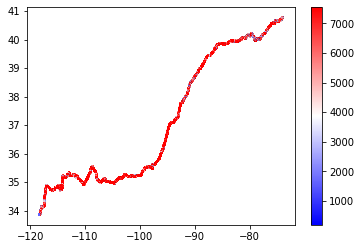

In [21]:
# rolling average of radii
radii = pd.Series(radii).rolling(window=20,center=True).mean().to_numpy()

plt.scatter(lons,lats,c=radii,cmap='bwr', s=1)
plt.colorbar()